<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/vits/vlms/nanoVLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
## Imports

In [5]:
import math, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [6]:
## Variables

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 32
EMBED_DIM = 64
ATTENTION_HEADS = 4
BATCH_SIZE = 12
EPOCHS = 10
LR = 3e-4
TEMPERATURE = 0.07

In [8]:
## Synthetic Dataset

In [9]:
colors = ["red", "green", "blue", "yellow", "purple", "orange", "pink", "brown", "gray"]
shapes = ["square", "circle", "triangle"]
positions = ["left", "center", "right", "top", "bottom", "top-left", "top-right", "bottom-left", "bottom-right"]

In [10]:
### Drawing image shapes

In [11]:
def draw_sample(color, shape, position, img_size=IMG_SIZE):
  img = Image.new("RGB", (img_size, img_size), "white")
  draw = ImageDraw.Draw(img)
  margin = 6
  w = h = img_size - 2 * margin

  # Calculate the coordinates
  if "left" in position:
    x0 = margin
    x1 = margin + w // 2
  elif "top-left" in position:
    x0 = margin
    x1 = margin + w // 2
  elif "bottom-left" in position:
    x0 = margin
    x1 = margin + w // 2
  elif "right" in position:
    x0 = margin + w // 2
    x1 = img_size - margin
  elif "top-right" in position:
    x0 = margin + w // 2
    x1 = img_size - margin
  elif "bottom-right" in position:
    x0 = margin + w // 2
    x1 = img_size - margin
  else:
    x0 = margin + w // 4
    x1 = margin + h // 2


  # Calculate y coordinates
  if "top" in position:
    y0 = margin
    y1 = margin + h // 2
  elif "top-left" in position:
    y0 = margin
    y1 = margin + h // 2
  elif "top-right" in position:
    y0 = margin
    y1 = margin + h // 2
  elif "bottom" in position:
    y0 = margin + h // 2
    y1 = img_size - margin
  elif "bottom-left" in position:
    y0 = margin + h // 2
    y1 = img_size - margin
  elif "bottom-right" in position:
    y0 = margin + h // 2
    y1 = img_size - margin
  else:
    y0 = margin + h // 4
    y1 = margin + 3 * h // 4

  if shape == "square":
    draw.rectangle([x0, y0, x1, y1], fill=color, outline="black")
  elif shape == "circle":
    draw.ellipse([x0, y0, x1, y1], fill=color, outline="black")
  else:
    draw.polygon([((x1+x0)//2, y0), (x0, y1), (x1, y1)], fill=color, outline="black")

  return img



In [12]:
## Class for building the dataset

In [13]:
class ShapesDataset():
  def __init__(self):
    self.images = []
    self.captions = []

    for c in colors:
      for s in shapes:
        for p in positions:
          img = draw_sample(c, s, p)
          cap = f"{c} {s} {p}"
          self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0)
          self.captions.append(cap)

    self.vocab, self.word2idx = self.build_vocab(self.captions)

  def build_vocab(self, texts):
    words = sorted({w for t in texts for w in t.split()})
    vocab = ["[CLS]"] + words
    w2i = {w:i for i,w in enumerate(vocab)}
    return vocab, w2i

  def __len__(self):
    return len(self.images)

  def encode_text(self, text):
    toks = [self.word2idx["[CLS]"]] + [self.word2idx[w] for w in text.split()]
    return torch.tensor(toks, dtype=torch.long)

  def __getitem__(self,  idx):
    return self.images[idx], self.encode_text(self.captions[idx])

In [14]:
## Create Dataset

In [15]:
full_ds = ShapesDataset()
VOCAB_SIZE = len(full_ds.vocab)
print(VOCAB_SIZE)
print(full_ds.vocab)

22
['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'center', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


/tmp/ipython-input-3026023183.py:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0)


In [16]:
## Train - Val data creation

In [17]:
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

In [18]:
## Dataloader

In [19]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
## Display a simple data point

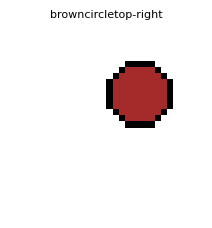

In [21]:
imgs, encoded_caps = next(iter(train_loader))
idx = random.randint(0, len(imgs) - 1)
img = (imgs[idx].permute(1,2,0).numpy() * 255).astype(np.uint8) # Convert to displayable image

# Decode the caption
caption_tokens = encoded_caps[idx].tolist()
caption = "".join([full_ds.vocab[token] for token in caption_tokens if token in range(len(full_ds.vocab))])
# Remove the [CLS] token from the displayed caption
caption = caption.replace("[CLS]", "")

plt.figure(figsize=(2.5, 2.5))
plt.imshow(img)
plt.title(caption, fontsize=8)
plt.axis("off")
plt.show()

In [22]:
## Image Encoder

In [23]:
class ImageEncoder(nn.Module):

  def __init__(self):
    super().__init__()
    self.convolutions = nn.Sequential(
      nn.Conv2d(3, 32, 3, 2, 1),
      nn.ReLU(),
      nn.Conv2d(32, 64, 3, 2, 1),
      nn.ReLU(),
      nn.Conv2d(64, 128, 3, 2, 1),
      nn.ReLU(),
      nn.Conv2d(128, 256, 3, 2, 1)
    )

    self.projection = nn.Linear(256, embed_dim)
    self.layernorm1 = nn.LayerNorm(embed_dim)

  def forward(self, x):
    x = self.convolutions(x)
    x = x.mean(dim=[2,3])
    x = self.projection(x)
    x = F.normalize(self.layernorm(x), dim=-1)
    return x

In [24]:
## Text Encoder

In [25]:
class TextEncoder(nn.Module):

  def __init__(self, embed_dim = EMBED_DIM, num_heads = ATTENTION_HEADS, vocab_size = VOCAB_SIZE, context_window = 4):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, embed_dim)
    self.position_embedding = nn.Embedding(context_window, embed_dim)
    self.mha = nn.MultiheadAttention(embed_dim, num_heads)
    self.projection = nn.Linear(embed_dim, embed_dim)
    self.norm = nn.LayerNorm(embed_dim)

  def forward(self, toks):
   N, L = toks.shape
   position_embedding = torch.arange(L, device=toks.device).unsequeeze(0).expand(N, L)
   final_embedding = self.token_embedding(toks) + self.position_embedding(position_embedding)
   context_vectors = self.mha(final_embedding, final_embedding, final_embedding)[0]
   final_token = context_vectors[:,0]
   projection = self.projection(final_token)
   output = F.normalize(self.norm(projection), dim=-1)
   return output

In [26]:
## CLIP loss